# Fine Tuning Transformer for MultiLabel Text Classification in Simplified Chinese

### Introduction

This notebook is a demonstration of MultiLabel Text Classification in Simplified Chinese with the paper: [Dataset of Propaganda Techniques of the State-Sponsored Information Operation of the People’s Republic of China](https://paperswithcode.com/sota/multi-label-text-classification-on-dataset-of?p=dataset-of-propaganda-techniques-of-the-state)

In the paper, we present our dataset that focuses on propaganda techniques in Mandarin based on a state-linked information operations dataset from the PRC released by Twitter in July 2019. The dataset consists of multi-label propaganda techniques of the sampled tweets.

In total, we have 9,950 labeled tweets with 21 different propaganda techniques. The tweets are the state-linked information operations dataset from the PRC released by Twitter.

Detailed steps of how to get the dataset can be found in the [Propaganda Tech Twitter PRC github page](https://github.com/annabechang/Propaganda_Tech_Twitter_PRC)


A lot of the Framework of this multilabel text classification come from the [hugging face tutorial notebook](https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_multi_label_classification.ipynb)

In this tutorial we will be fine tuning a transformer model for the **Multilabel text classification** problem in simplified chinese. 


#### Flow of the notebook

The notebook will be divided into seperate sections to provide a organized walk through for the process used. This process can be modified for individual use cases. The sections are:

1. [Importing Python Libraries and preparing the environment](#section01)
2. [Importing and Pre-Processing the domain data](#section02)
3. [Preparing the Dataset and Dataloader](#section03)
4. [Creating the Neural Network for Fine Tuning](#section04)
5. [Fine Tuning the Model](#section05)
6. [Validating the Model Performance](#section06)
7. [Saving the model and artifacts for Inference in Future](#section07)

#### Technical Details

This script leverages on multiple tools designed by other teams. Details of the tools used below. Please ensure that these elements are present in your setup to successfully implement this script.

 - Data: 
	 - We are using the dataset from [Twitter](https://transparency.twitter.com/en/reports/information-operations.html) in combination with the propaganda techniques we created for [the paper](https://github.com/annabechang/Propaganda_Tech_Twitter_PRC)


 - Language Model Used:
	 - BERT is used for this project. It was the transformer model created by the Google AI Team.  
	 - [Blog-Post](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)
	 - [Research Paper](https://arxiv.org/abs/1810.04805)
     - [Documentation for python](https://huggingface.co/transformers/model_doc/bert.html)
     - [ckiplab/bert-base-chinese](https://huggingface.co/ckiplab/bert-base-chinese) we will use the bert-base-chinese pre trained model from CKIP Lab on hugging face.

 - Hardware Requirements:
	 - Python 3.6 and above
	 - Pytorch, Transformers and All the stock Python ML Libraries
	 - GPU enabled setup 




<a id='section01'></a>
### Importing Python Libraries and preparing the environment

At this step we will be importing the libraries and modules needed to run our script. Libraries are:
* Pandas
* Pytorch
* Pytorch Utils for Dataset and Dataloader
* Transformers
* BERT Model and Tokenizer


In [76]:
# Installing the transformers library 

#!pip install -q transformers

In [77]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import *
# Preparing for TPU usage
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

In [78]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [79]:
pd.set_option("display.max_columns", None)

<a id='section02'></a>
### Importing and Pre-Processing the domain data

We will be working with the data and preparing for fine tuning purposes. 


Once you follower the steps on our github page,
download the twitter dataset and combine it with our labels, you will make this training data file. 

In this example we are naming it `tweet_lang_groupby_zh_LABEL3_9951_clean.csv`. 




In [93]:
df=pd.read_csv("tweet_lang_groupby_zh_LABEL3_9951_clean.csv",index_col=0)

In [94]:
df = df.reset_index(drop=True)

In [95]:
df

,tweetid,rm_emoji,Label
0,1081524597713846272,看你挺瘦 浑身是力气：（来自YouTube）,20
1,1146246401778581504,是谁谁在叨叨不休是躺在床上的姥姥还是依着门框的母亲是谁谁把泥泞踩得呻吟是父亲驮着犁牵着那条老...,20
2,1081169699591860229,篮球 只能用这背景音乐来表达了！ 神童！：（来自YouTube）,20
3,1081165946700685313,滥情先生碰上深情女士 犹如钓到白鲸 最后不是他遗弃你而是他无处安放你,20
4,1121228261143433217,李一平就是个民主骗子，想着法子骗大家为他卖命，这种哗众取宠的小丑大家一定要看清楚他的真面目，...,"3,8"
...,...,...,...
9946,1013579702114574336,198920042014: abc139528985051 YurikooLee 同一性质的...,20
9947,929219593926791168,WeipingQin: 上海携程虐童案 携程创始人梁建章：公司中高层基本上没有安全感，都...,19
9948,915395954798346240,kittylove331: wanli198964 郭文贵，作为一名通辑犯，你在大陆偷税漏税...,"3,8,9"
9949,922764220353077248,OsKrO1rfUZVmTd5: imqFHMLGtqXfRbq 能力有大小，水平有高低，凡...,20


In [96]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9951 entries, 0 to 9950
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweetid   9951 non-null   int64 
 1   rm_emoji  9951 non-null   object
 2   Label     9951 non-null   object
dtypes: int64(1), object(2)
memory usage: 233.4+ KB


In [98]:
df

,tweetid,rm_emoji,Label
0,1081524597713846272,看你挺瘦 浑身是力气：（来自YouTube）,20
1,1146246401778581504,是谁谁在叨叨不休是躺在床上的姥姥还是依着门框的母亲是谁谁把泥泞踩得呻吟是父亲驮着犁牵着那条老...,20
2,1081169699591860229,篮球 只能用这背景音乐来表达了！ 神童！：（来自YouTube）,20
3,1081165946700685313,滥情先生碰上深情女士 犹如钓到白鲸 最后不是他遗弃你而是他无处安放你,20
4,1121228261143433217,李一平就是个民主骗子，想着法子骗大家为他卖命，这种哗众取宠的小丑大家一定要看清楚他的真面目，...,"3,8"
...,...,...,...
9946,1013579702114574336,198920042014: abc139528985051 YurikooLee 同一性质的...,20
9947,929219593926791168,WeipingQin: 上海携程虐童案 携程创始人梁建章：公司中高层基本上没有安全感，都...,19
9948,915395954798346240,kittylove331: wanli198964 郭文贵，作为一名通辑犯，你在大陆偷税漏税...,"3,8,9"
9949,922764220353077248,OsKrO1rfUZVmTd5: imqFHMLGtqXfRbq 能力有大小，水平有高低，凡...,20


In [99]:
# we noticed some abnormal labels happened in the manual labeling process
# this step is to fix such errors. 
# including replaceing dot with comma, mistyped ? mark, replacing number of fullwidth to halfwidth, adding comma back etc

df.Label = df.Label.apply(lambda x: ',' if '.' in x else x)
df.Label = df.Label.apply(lambda x: '' if '?' in x else x)
df.Label = df.Label.apply(lambda x: '3' if '３' in x else x)
df.Label = df.Label.apply(lambda x: '3' if ' 3' in x else x)
df.Label = df.Label.apply(lambda x: '8' if '８' in x else x)
df.Label = df.Label.apply(lambda x: '9' if '９' in x else x)
df.Label = df.Label.apply(lambda x: '12' if ' 12' in x else x)
df.Label = df.Label.apply(lambda x: '8,7' if '87' in x else x)


In [100]:
df

,tweetid,rm_emoji,Label
0,1081524597713846272,看你挺瘦 浑身是力气：（来自YouTube）,20
1,1146246401778581504,是谁谁在叨叨不休是躺在床上的姥姥还是依着门框的母亲是谁谁把泥泞踩得呻吟是父亲驮着犁牵着那条老...,20
2,1081169699591860229,篮球 只能用这背景音乐来表达了！ 神童！：（来自YouTube）,20
3,1081165946700685313,滥情先生碰上深情女士 犹如钓到白鲸 最后不是他遗弃你而是他无处安放你,20
4,1121228261143433217,李一平就是个民主骗子，想着法子骗大家为他卖命，这种哗众取宠的小丑大家一定要看清楚他的真面目，...,"3,8"
...,...,...,...
9946,1013579702114574336,198920042014: abc139528985051 YurikooLee 同一性质的...,20
9947,929219593926791168,WeipingQin: 上海携程虐童案 携程创始人梁建章：公司中高层基本上没有安全感，都...,19
9948,915395954798346240,kittylove331: wanli198964 郭文贵，作为一名通辑犯，你在大陆偷税漏税...,"3,8,9"
9949,922764220353077248,OsKrO1rfUZVmTd5: imqFHMLGtqXfRbq 能力有大小，水平有高低，凡...,20


In [101]:
# in this step we are transforming the label format into a one hot encoding format 

lab_trans = pd.DataFrame(mlb.fit_transform(df['Label'].str.split(',')),columns=mlb.classes_)
lab_trans
    

,,1,10,11,12,13,14,16,17,18,19,2,20,21,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9946,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9947,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9948,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
9949,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [102]:
lab_trans.columns

Index(['', '1', '10', '11', '12', '13', '14', '16', '17', '18', '19', '2',
       '20', '21', '3', '4', '5', '6', '7', '8', '9'],
      dtype='object')

In [103]:
lab_trans=lab_trans.drop([''], axis=1)
lab_trans

,1,10,11,12,13,14,16,17,18,19,2,20,21,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9946,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9947,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9948,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
9949,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [104]:
df_lb = pd.concat([df, lab_trans], axis=1)
df_lb

,tweetid,rm_emoji,Label,1,10,11,12,13,14,16,17,18,19,2,20,21,3,4,5,6,7,8,9
0,1081524597713846272,看你挺瘦 浑身是力气：（来自YouTube）,20,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1146246401778581504,是谁谁在叨叨不休是躺在床上的姥姥还是依着门框的母亲是谁谁把泥泞踩得呻吟是父亲驮着犁牵着那条老...,20,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1081169699591860229,篮球 只能用这背景音乐来表达了！ 神童！：（来自YouTube）,20,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,1081165946700685313,滥情先生碰上深情女士 犹如钓到白鲸 最后不是他遗弃你而是他无处安放你,20,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1121228261143433217,李一平就是个民主骗子，想着法子骗大家为他卖命，这种哗众取宠的小丑大家一定要看清楚他的真面目，...,"3,8",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9946,1013579702114574336,198920042014: abc139528985051 YurikooLee 同一性质的...,20,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9947,929219593926791168,WeipingQin: 上海携程虐童案 携程创始人梁建章：公司中高层基本上没有安全感，都...,19,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9948,915395954798346240,kittylove331: wanli198964 郭文贵，作为一名通辑犯，你在大陆偷税漏税...,"3,8,9",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
9949,922764220353077248,OsKrO1rfUZVmTd5: imqFHMLGtqXfRbq 能力有大小，水平有高低，凡...,20,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [105]:
df_lb.to_csv("tweet_zh_9951_label_trans.csv",encoding='utf-8')

In [106]:
df = pd.read_csv("tweet_zh_9951_label_trans.csv",index_col=0)

In [107]:
df

,tweetid,rm_emoji,Label,1,10,11,12,13,14,16,17,18,19,2,20,21,3,4,5,6,7,8,9
0,1081524597713846272,看你挺瘦 浑身是力气：（来自YouTube）,20,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1146246401778581504,是谁谁在叨叨不休是躺在床上的姥姥还是依着门框的母亲是谁谁把泥泞踩得呻吟是父亲驮着犁牵着那条老...,20,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1081169699591860229,篮球 只能用这背景音乐来表达了！ 神童！：（来自YouTube）,20,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,1081165946700685313,滥情先生碰上深情女士 犹如钓到白鲸 最后不是他遗弃你而是他无处安放你,20,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1121228261143433217,李一平就是个民主骗子，想着法子骗大家为他卖命，这种哗众取宠的小丑大家一定要看清楚他的真面目，...,"3,8",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9946,1013579702114574336,198920042014: abc139528985051 YurikooLee 同一性质的...,20,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9947,929219593926791168,WeipingQin: 上海携程虐童案 携程创始人梁建章：公司中高层基本上没有安全感，都...,19,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9948,915395954798346240,kittylove331: wanli198964 郭文贵，作为一名通辑犯，你在大陆偷税漏税...,"3,8,9",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
9949,922764220353077248,OsKrO1rfUZVmTd5: imqFHMLGtqXfRbq 能力有大小，水平有高低，凡...,20,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [114]:
df.columns

Index(['tweetid', 'rm_emoji', 'Label', '1', '10', '11', '12', '13', '14', '16',
       '17', '18', '19', '2', '20', '21', '3', '4', '5', '6', '7', '8', '9'],
      dtype='object')

In [115]:
df.describe()

,tweetid,1,10,11,12,13,14,16,17,18,19,2,20,21,3,4,5,6,7,8,9
count,9.951000e+03,9951.000000,9951.000000,9951.000000,9951.000000,9951.000000,9951.000000,9951.000000,9951.000000,9951.00000,9951.000000,9951.000000,9951.000000,9951.000000,9951.000000,9951.000000,9951.000000,9951.000000,9951.000000,9951.000000,9951.000000
mean,1.013417e+18,0.001306,0.011456,0.008140,0.014772,0.014169,0.003718,0.006432,0.008341,0.00603,0.091951,0.000201,0.614712,0.000502,0.252135,0.003718,0.001206,0.005025,0.026630,0.232439,0.262185
std,7.438823e+16,0.036122,0.106424,0.089858,0.120647,0.118195,0.060867,0.079942,0.090951,0.07742,0.288971,0.014176,0.486688,0.022411,0.434260,0.060867,0.034707,0.070710,0.161009,0.422409,0.439845
min,3.613167e+17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.515512e+17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.012231e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.070723e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.153122e+18,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [108]:
LABEL_COLUMNS = df.columns.tolist()[3:]

In [109]:
LABEL_COLUMNS

['1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

##### here we are plotting a distribution of different labels

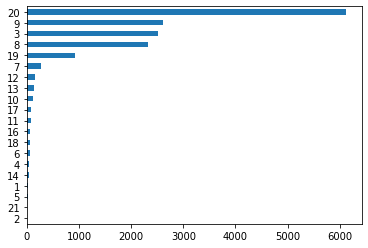

In [110]:
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

In [111]:
df[LABEL_COLUMNS].sum().sort_values()

2        2
21       5
5       12
1       13
14      37
4       37
6       50
18      60
16      64
11      81
17      83
10     114
13     141
12     147
7      265
19     915
8     2313
3     2509
9     2609
20    6117
dtype: int64

In [112]:
x = pd.DataFrame(df[LABEL_COLUMNS].sum().sort_values())
x.columns=['Frequency']
x

,Frequency
2,2
21,5
5,12
1,13
14,37
4,37
6,50
18,60
16,64
11,81


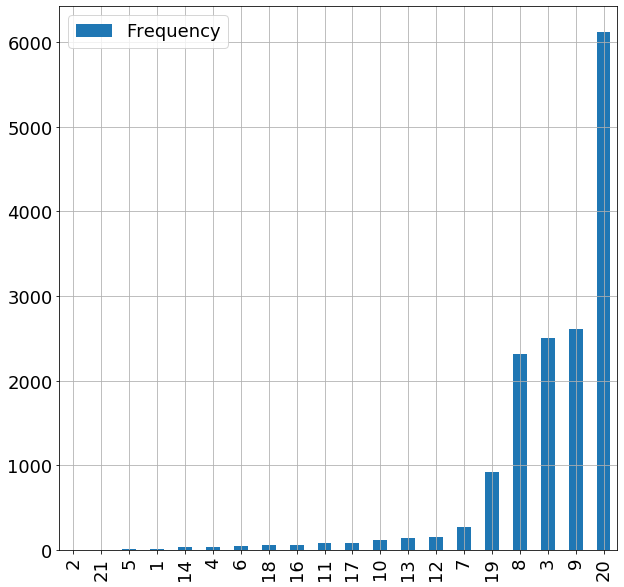

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline

x.plot(grid=True,figsize=(10,10), kind='bar')
plt.tick_params(labelsize=18)
#plt.title('Language usage of more than 10,000 times each year',fontsize=20)
#plt.xlabel("Year", fontsize=18)
#plt.ylabel("Tweet Language Usage", fontsize=18)
plt.legend(fontsize=18)

plt.savefig("Label_freq.jpeg", dpi=100)

In [116]:
#create a clean dataframe with only tweet and tweet id
new_df = df[['tweetid', 'rm_emoji']]
new_df

,tweetid,rm_emoji
0,1081524597713846272,看你挺瘦 浑身是力气：（来自YouTube）
1,1146246401778581504,是谁谁在叨叨不休是躺在床上的姥姥还是依着门框的母亲是谁谁把泥泞踩得呻吟是父亲驮着犁牵着那条老...
2,1081169699591860229,篮球 只能用这背景音乐来表达了！ 神童！：（来自YouTube）
3,1081165946700685313,滥情先生碰上深情女士 犹如钓到白鲸 最后不是他遗弃你而是他无处安放你
4,1121228261143433217,李一平就是个民主骗子，想着法子骗大家为他卖命，这种哗众取宠的小丑大家一定要看清楚他的真面目，...
...,...,...
9946,1013579702114574336,198920042014: abc139528985051 YurikooLee 同一性质的...
9947,929219593926791168,WeipingQin: 上海携程虐童案 携程创始人梁建章：公司中高层基本上没有安全感，都...
9948,915395954798346240,kittylove331: wanli198964 郭文贵，作为一名通辑犯，你在大陆偷税漏税...
9949,922764220353077248,OsKrO1rfUZVmTd5: imqFHMLGtqXfRbq 能力有大小，水平有高低，凡...


In [117]:
#concatenate the tweets with the labels 
new_df['list']=df[LABEL_COLUMNS].values.tolist()
new_df


/home/user/anaconda3/envs/tfgpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,tweetid,rm_emoji,list
0,1081524597713846272,看你挺瘦 浑身是力气：（来自YouTube）,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
1,1146246401778581504,是谁谁在叨叨不休是躺在床上的姥姥还是依着门框的母亲是谁谁把泥泞踩得呻吟是父亲驮着犁牵着那条老...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
2,1081169699591860229,篮球 只能用这背景音乐来表达了！ 神童！：（来自YouTube）,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,1081165946700685313,滥情先生碰上深情女士 犹如钓到白鲸 最后不是他遗弃你而是他无处安放你,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
4,1121228261143433217,李一平就是个民主骗子，想着法子骗大家为他卖命，这种哗众取宠的小丑大家一定要看清楚他的真面目，...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...
9946,1013579702114574336,198920042014: abc139528985051 YurikooLee 同一性质的...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
9947,929219593926791168,WeipingQin: 上海携程虐童案 携程创始人梁建章：公司中高层基本上没有安全感，都...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
9948,915395954798346240,kittylove331: wanli198964 郭文贵，作为一名通辑犯，你在大陆偷税漏税...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
9949,922764220353077248,OsKrO1rfUZVmTd5: imqFHMLGtqXfRbq 能力有大小，水平有高低，凡...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [118]:
new_df.to_csv("tweet_zh_9951_label_trans2_conc_lab.csv",encoding='utf-8')

In [119]:
new_df.columns

Index(['tweetid', 'rm_emoji', 'list'], dtype='object')

In [120]:
new_df.columns = ['tweetid', 'comment_text', 'list']

In [121]:
new_df

,tweetid,comment_text,list
0,1081524597713846272,看你挺瘦 浑身是力气：（来自YouTube）,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
1,1146246401778581504,是谁谁在叨叨不休是躺在床上的姥姥还是依着门框的母亲是谁谁把泥泞踩得呻吟是父亲驮着犁牵着那条老...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
2,1081169699591860229,篮球 只能用这背景音乐来表达了！ 神童！：（来自YouTube）,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,1081165946700685313,滥情先生碰上深情女士 犹如钓到白鲸 最后不是他遗弃你而是他无处安放你,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
4,1121228261143433217,李一平就是个民主骗子，想着法子骗大家为他卖命，这种哗众取宠的小丑大家一定要看清楚他的真面目，...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...
9946,1013579702114574336,198920042014: abc139528985051 YurikooLee 同一性质的...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
9947,929219593926791168,WeipingQin: 上海携程虐童案 携程创始人梁建章：公司中高层基本上没有安全感，都...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
9948,915395954798346240,kittylove331: wanli198964 郭文贵，作为一名通辑犯，你在大陆偷税漏税...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
9949,922764220353077248,OsKrO1rfUZVmTd5: imqFHMLGtqXfRbq 能力有大小，水平有高低，凡...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [122]:
#checking how the labels looks like
new_df['list'][0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [123]:
#checking the length of the labels 
len(new_df['list'][0])

20

<a id='section03'></a>
### Preparing the Dataset and Dataloader


In [124]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 100 #200
TRAIN_BATCH_SIZE = 2 #4
VALID_BATCH_SIZE = 2
EPOCHS = 2 #1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')

In [125]:
#sampling a tweet to see 
" ".join((str(new_df.comment_text[0])).split())

'看你挺瘦 浑身是力气：（来自YouTube）'

In [126]:
#testing and visualizing the tokenizer
sen_code =  tokenizer.encode_plus('今天天氣真 Good。',None,
            add_special_tokens=True,
            max_length=200,
            pad_to_max_length=True,
            return_token_type_ids=True)
print(sen_code)


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'input_ids': [101, 791, 1921, 1921, 3706, 4696, 100, 511, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [127]:
print(tokenizer.convert_ids_to_tokens(sen_code['input_ids']))

['[CLS]', '今', '天', '天', '氣', '真', '[UNK]', '。', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

In [128]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [129]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=new_df.sample(frac=train_size,random_state=200)
test_dataset=new_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (9951, 3)
TRAIN Dataset: (7961, 3)
TEST Dataset: (1990, 3)


In [130]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [131]:
training_loader

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

In [132]:
torch.cuda.empty_cache()
import gc

gc.collect()

9417

In [133]:
torch.cuda.ipc_collect()

In [134]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-chinese')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 20) # 18 labels
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [135]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [136]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

<a id='section05'></a>
### Fine Tuning the Model

In [137]:
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [138]:
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  0.7110204696655273
Epoch: 1, Loss:  0.059535570442676544


<a id='section06'></a>
### Validating the Model

During the validation stage we pass the unseen data(Testing Dataset) to the model. This step determines how good the model performs on the unseen data. 

This unseen data is the 20% of `train.csv` which was seperated during the Dataset creation stage. 
During the validation stage the weights of the model are not updated. Only the final output is compared to the actual value. This comparison is then used to calcuate the accuracy of the model. 

As defined above to get a measure of our models performance we are using the following metrics. 
- Accuracy Score
- F1 Micro
- F1 Macro

We are getting amazing results for all these 3 categories just by training the model for 1 Epoch.

In [140]:
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [141]:
for epoch in range(EPOCHS):
    outputs, targets = validation(epoch)
    outputs = np.array(outputs) >= 0.5
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")

/home/user/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Accuracy Score = 0.8035175879396985
F1 Score (Micro) = 0.85431352802954
F1 Score (Macro) = 0.20802549034676968
Accuracy Score = 0.8035175879396985
F1 Score (Micro) = 0.85431352802954
F1 Score (Macro) = 0.20802549034676968


<a id='section07'></a>
### Saving the Trained Model Artifacts for inference

In [144]:
output_model_file = './pytorch_distilbert_news_9951.bin'
output_vocab_file = './vocab_distilbert_news_9951.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')
print('This tutorial is completed')

All files saved
This tutorial is completed


In [145]:
tokenizer.save_pretrained(output_vocab_file)

('./vocab_distilbert_news_9951.bin/vocab.txt',
 './vocab_distilbert_news_9951.bin/special_tokens_map.json',
 './vocab_distilbert_news_9951.bin/added_tokens.json')